## Simple Notebook to Check VCF Similarity
This uses a simple similarity score, determining which patients among two different demultiplexing outputs are likely representing the same person. It looks at the VCF and does a simple similarity score, looking at how many sites (out of the total number of sites) are identical between all pairwise individuals.

In general, I usually only import VCFs after they've been processed a certain amount. From bulk RNA reads (using the GATK HaplotypeCaller tool), I generally run:

`gatk -T VariantAnnotator -R /path/to/genome.fa -V my.vcf.gz -o my.1kg.vcf.gz --dbsnp /path/to/human_9606.1kG.00-common_all.vcf.gz # this file available on Ye Lab S3`
`gatk -R /path/to/genome.fa -T SelectVariants --variant my.1kg.vcf.gz -o my.1kg.filt.vcf.gz --restrictAllelesTo BIALLELIC --selectTypeToInclude SNP -select 'DB'`

If your VCFs came from plink files, they may not have AN/AC tags. You can add those with: 

`bcftools +fill-tags in.vcf.gz -Oz -o out.vcf.gz -- -t AN,AC`

And then do the same processing above. 

If you choose not to annotate according to 1KG using the SelectVariants tool, you should still restrict your VCF to SNPs only, since this notebook was not written to handle them. SelectVariants does this with the `--selecttTypeToInclude` tag, but it can also be achieved with:

`vcftools --gzvcf my.vcf.gz --remove-indels --recode --recode-INFO-all --out my.snpsonly.vcf.gz`

In [1]:
import pandas as pd
import numpy as np
import itertools as it
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle as pkl
import gzip
from functools import reduce
import seaborn as sns

I like to store everything in dictionaries.

In [20]:
vcfs = dict()
prefix = '/data/codec/'

Give your VCFs labels and file paths:

In [21]:
vcf_labels = ['snparray','freemux']
vcf_paths = ['vcfs/noempty.hg38.liftover.nochr.hg38tag.vcf.gz', 
             'dscpileup.freemux.outs/freemux.out/freemux.clust1.vcf.gz',
            ]

### Load them in. 

I was typically doing this with `pd.read_csv` but unfortunately the structure of VCFs makes this intractible. The `skiprows` parameter requires information you can only get from the command line. And the `comments` parameter to does not allow for two-character comment codes (which you'd need to skip the `##` lines up top). Also, it's easier to filter the VCF upon loading in for only the information we want (namely, a few of the site identifiers and the GT field) rather than load the whole VCF in and then remove info. For that reason, I parse the files manually myself: 

In [22]:
# I HATEEEEEEE VCFs
# the fact that this code needs to be so complicated must mean it is not a very good format
# everything should be stored in SEPARATE compressed data matrices, separate GT/GP/
for label, path in tqdm(zip(vcf_labels, vcf_paths), total=2):
    
    vcfs[label] = dict() # the values of the dict themselves will also be dictionaries
    vcfs[label]['path'] = prefix + path # add the path as a dictinoary key and value
    
    # want to skip a certain number, assuming your VCF does not have a header > 1000 lines
    vcfs[label]['skip'] = !zcat {vcfs[label]['path']} | head -n 1000 | grep "#" | wc -l
    vcfs[label]['skip'] = int(vcfs[label]['skip'][0]) - 1 # still want to keep the last line
    
    # read the file
    vcfs[label]['file'] = gzip.open(vcfs[label]['path'],'rt')
    for i in range(vcfs[label]['skip']):
        vcfs[label]['file'].readline()
        
    # create a list to build
    vcfs[label]['gts'] = list()
    vcfs[label]['uids'] = list()
    vcfs[label]['info'] = list()
    
    # add the single-line header
    header = vcfs[label]['file'].readline().strip().split('\t')
    
    # for the rest of them, take the most important information only
    for line in tqdm(vcfs[label]['file']):
        line = line.strip().split('\t')

        uid = ":".join([line[0], line[1], line[3], line[4]])
        vcfs[label]['uids'].append(uid)
        
        gts = [i.split(":")[0] for i in line[9:]]
        vcfs[label]['gts'].append(gts)
        
        infoline = [i.split('=') for i in line[7].split(";") if "=" in i]
        vcfs[label]['info'].append(dict(zip([i[0] for i in infoline], [i[1] for i in infoline])))
        
    vcfs[label]['info'] = pd.DataFrame(vcfs[label]['info'],
                                       index=vcfs[label]['uids']).astype(np.float32)
    vcfs[label]['info'].index.name='ID'
    
    vcfs[label]['gts'] = pd.DataFrame(vcfs[label]['gts'], 
                                     index=vcfs[label]['uids'],
                                     columns=header[9:])
    vcfs[label]['gts'].index.name='ID'
    
    vcfs[label]['uids'].append(uid)
    # delete the list to reduce memory now

### Clean Up VCFs

Get rid of any sites that may be duplicated.

In [23]:
for i in vcf_labels:
    vcfs[i]['gts'] = vcfs[i]['gts'][~vcfs[i]['gts'].index.duplicated()] # will drop the the second instance of an ID if it was seen already
    vcfs[i]['info'] = vcfs[i]['info'][~vcfs[i]['info'].index.duplicated()]

In [24]:
for label in vcf_labels:
    print(label + ' ' + str(vcfs[label]['gts'].columns))

snparray Index(['IGTB1952', 'IGTB1966', 'IGTB1826', 'IGTB1828', 'IGTB1871'], dtype='object')
freemux Index(['CLUST0', 'CLUST1', 'CLUST2', 'CLUST3', 'CLUST4'], dtype='object')


Some naming conventions will be changed for consistency. Furthermore, it _seems_ that `A1-004_Neely_10` should be `A2-004_Neely_10`, this was a transcription error from the genotyping core.

### Join and Clean up

Join all VCFs on the inner join of sites. If these VCFs came from two different freemuxlet outputs using the same input list of sites, this should not remove any sites.

In [25]:
for label in vcf_labels:
    vcfs[label]['gts'].index.name='ID'

In [26]:
joined = reduce(lambda left,right: pd.merge(left,right,on='ID'), [vcfs[label]['gts'] for label in vcf_labels])

Reduce object size by replacing strings with single digit identifiers.

In [29]:
joined.replace('./.',-1,inplace=True)
joined.replace('0/0',0,inplace=True)
joined.replace('0/1',1,inplace=True)
joined.replace('1/1',2,inplace=True)

### Comparisons

Extract out our patient ID columns:

In [30]:
patient_ids = joined.columns
print(patient_ids)

Index(['IGTB1952', 'IGTB1966', 'IGTB1826', 'IGTB1828', 'IGTB1871', 'CLUST0',
       'CLUST1', 'CLUST2', 'CLUST3', 'CLUST4'],
      dtype='object')


Make combinations of all of them, without repeats. Note here that if any of your column names are the same (i.e. you're comparing two freemuxlet results) the combinations can get confusing, so **now would be a good time to rename your columns to something more descriptive**.

In [31]:
combos = list(it.product(patient_ids[:5],patient_ids[5:]))
combos[:10]

[('IGTB1952', 'CLUST0'),
 ('IGTB1952', 'CLUST1'),
 ('IGTB1952', 'CLUST2'),
 ('IGTB1952', 'CLUST3'),
 ('IGTB1952', 'CLUST4'),
 ('IGTB1966', 'CLUST0'),
 ('IGTB1966', 'CLUST1'),
 ('IGTB1966', 'CLUST2'),
 ('IGTB1966', 'CLUST3'),
 ('IGTB1966', 'CLUST4')]

Subsample only 2000 sites because using all sites will probably take very very long to compare.

In [32]:
# joinedsub = joined.sample(10000)

In [39]:
sims = pd.DataFrame(index=patient_ids[:5], columns=patient_ids[5:], dtype=np.float32) # similarities
numsites = len(joined)
siterange = joined.index
for i,j in tqdm(combos):
    comp = joined[[i,j]].values
    
    #only use sites where both genotypes have been called
    comp = comp[(comp == -1).sum(axis=1) < 1]
    
    #only use sites with at least one allele present in the pairwise comparison
#     comp = comp[comp.sum(axis=1) > 0]
    
    # myfrac is percentage of those sites that are identical between the two individuals
    myfrac = sum([i[0] == i[1] for i in comp])/numsites
    sims.loc[i,j] = myfrac
    

### Matching People
Here you should *hopefully* see that there is a clear population of combinations with very high similarity as compared to the null distribution of random combination. In the graph below, it's actually not super clear but I've run on other datasets where its definitely more clear. If these are two different freemuxlet results that have the same pool of people and used the same VCF, it should be night and day, since the VCF was *literally generated to maximize the genetic distance between droplets*. 

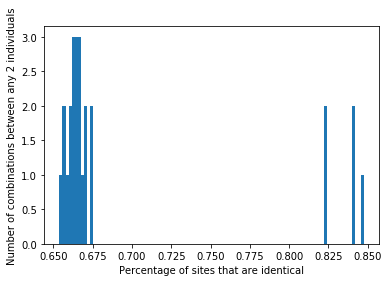

In [40]:
plt.hist(np.ravel(sims.values),bins=100)
# plt.yscale('log')
plt.xlabel('Percentage of sites that are identical')
plt.ylabel('Number of combinations between any 2 individuals');

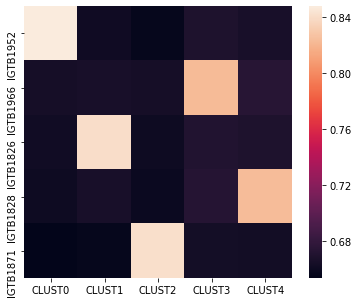

In [43]:
plt.figure(figsize=(6,5));
sns.heatmap(sims);

And that's pretty much it. Hopefully you get great results!